<a href="https://colab.research.google.com/github/Chenzhang0329/Credit_Score_Classification/blob/main/6100_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive summary

This study is using a banking dataset posted on Kaggle.
It contains 100,000 customers, with 27 different variables that hold the customer information. Based on these information, the financial institutions would like to make their credit report and determine an individual's credit score to make further decisions such as granting loans to the person or deciding the interest rate on the loans. Our goal will be to use these information to build machine
learning models that can classify the credit scores of the customers.

The original Kaggle dataset consists training data that spans from January to August, and test data from September to December. Since Kaggle does not provide solutions or any results for the test data, we split the training set so the January to July data is our new training set, and the August data is our validation set. We also added new variables from *Type_of_Loan* and *Payment_Behaviour*, cleaned the corrupted data, and removed variables that are redundant or not needed for training purposes.


After cleaning the data, three different models are trained. The validation accuracy for each was:

* Linear Regression: 59%
* Decision Tree: 68%
* Random Forest: 73%

# Ethics

There are a few ethical isses regarding this project. There may be added bias for our results, in particular related to how the corrupted values are treated. For instance, we filled the occupation and monthly salaries of the customers based on the other entries of the same customer. It is possible they changed their job and had a different monthly salary but was not recorded, leading to some bias for the data.

This dataset includes many of the clients' personal credit-related details, such as their names, homes, annual income, and so on. The release of personal information should require clients' consent, assuming they are real. Without their consent (of using their data for this task), the bank should not have released this dataset to us, as there are huge privacy concerns that may affect the individuals. A person with someone else's SSN, name and many other basic information can easily disguise as that other person and potentially take money from their bank or use their information for other purchases, essentially stealing money.

# Importing libraries and data

In [ ]:
###
# Upload and unzip data ("CreditScore.zip")
###

from google.colab import files
from zipfile import ZipFile

uploaded = files.upload()
with ZipFile('CreditScore.zip') as z:
    z.extractall()

Mounted at /content/drive


In [ ]:
# importing libraries
import math
import pandas as pd
import numpy as np

# Globally set the printing option 
pd.set_option('display.max_columns', None)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics, tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

In [ ]:
# importing data
train_data = pd.read_csv('/content/CreditScore/train.csv')
test_data = pd.read_csv('/content/CreditScore/test.csv')

train_data.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


# Data Cleaning

Data cleaning is done before any models are fit to the dataset. Kaggle provides the descriptions for this dataset, and based on the descriptions the following actions are done:


*   Converted variables into numbers if they fall into the following categories:


>> Originally was string (eg. *Age*, *Annual_Income*)

>> The values resemble some ordering (eg. *Month*)


*   Separated *Type_of_Loan* and *Payment_Behaviour* into different categories
*   One-hot encode dummy variables for categorical variables
*   Corrupt data: many data in this dataset is corrupt, including NA values and invalid values like "\_\_-500\_\_" for *Age*. Some ways we dealt with them are:

>> Filled with appropriate values

>> If an information entry was available for all but one place (e.g. age available for the same person except for one entry), use the previous entries

*   The variable *Month* is used to separate the training set into a train/validation set, as Kaggle does not provide the "answers" for the test set
*   *Customer_ID*, *Name*, *SSN*, *Type_of_Loan*, *Payment_Behaviour* are removed for training purposes


In [ ]:
#### Modify train and test data

# Transported is the value we want to predict
Credit_Score = train_data['Credit_Score']

# for data transformation

# Combine train and test
temp = [train_data, test_data]
# Remove Transported from train data to combine with test data
full_data = pd.concat(temp, keys=['train', 'test']).drop('Credit_Score', axis=1)

## Convert into numerical values

In [ ]:
# string to number (function)
def str_to_num(data):
  return pd.to_numeric(data.apply(lambda x: x.replace('_', '') if type(x) == str and '_' in x else x))

def new_column(data, prim_key, to_change, min_bound, max_bound):
  valid_vals = {}
  new_col = []
  #data[to_change] = pd.to_numeric(data[to_change])

  for x,y in zip(data[prim_key], data[to_change]):
    if x not in valid_vals:
      valid_vals[x] = []
    if not pd.isnull(y):
      if y not in valid_vals[x] and y >= min_bound and y <= max_bound:
        valid_vals[x].append(y)
  
  for x,y in zip(data[prim_key], data[to_change]):
    if y in valid_vals[x]:
      new_col.append(y)
    else:
      new_col.append(valid_vals[x][0])
  
  return valid_vals, new_col

In [ ]:
### string to number
full_data = pd.concat(temp, keys=['train', 'test']).drop('Credit_Score', axis=1)
# Age
full_data['Age'] = str_to_num(full_data['Age'])
_, full_data['Age'] = new_column(full_data, 'Customer_ID', 'Age', 0, 150)

# Annual_Income
full_data['Annual_Income'] = str_to_num(full_data['Annual_Income'])

# Num_of_Loan
#TODO: change after Type_of_Loan is converted

# Num_of_Delayed_Payment
full_data['Num_of_Delayed_Payment'] = str_to_num(full_data['Num_of_Delayed_Payment'])
_, full_data['Num_of_Delayed_Payment'] = new_column(full_data, 'Customer_ID', 'Num_of_Delayed_Payment', 
                                                    full_data['Num_of_Delayed_Payment'].min(), 
                                                    full_data['Num_of_Delayed_Payment'].max())

# Changed_Credit_Limit
full_data['Changed_Credit_Limit'] = str_to_num(full_data['Changed_Credit_Limit'])
_, full_data['Changed_Credit_Limit'] = new_column(full_data, 'Customer_ID', 'Changed_Credit_Limit', 
                                                   full_data['Changed_Credit_Limit'].min(), 
                                                   full_data['Changed_Credit_Limit'].max())

# Outstanding_Debt
full_data['Outstanding_Debt'] = str_to_num(full_data['Outstanding_Debt'])

# Credit_History_Age


# Amount_invested_monthly
full_data['Amount_invested_monthly'] = full_data['Amount_invested_monthly'].apply(lambda x: "0" if x == "__10000__" else x)
full_data['Amount_invested_monthly'] = str_to_num(full_data['Amount_invested_monthly'])
full_data['Amount_invested_monthly'].fillna(0, inplace=True)

In [ ]:
# rankings to numerical
convert_dict = {'Month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 
                          'May': 5, 'June': 6, 'July': 7, 'August': 8, 
                          'September': 9, 'October': 10, 'November': 11, 'December': 12},
                'Credit_Mix': {'Bad': -1, 'Standard': 0, 'Good': 1, '_':0},
                'Payment_of_Min_Amount': {'No': 0, 'NM': 0, 'Yes': 1}}

for var, conversion in convert_dict.items():
  for old_val, new_val in conversion.items():
    full_data.loc[full_data[var] == old_val, var] = new_val

## Create new variables from Type_of_Loan and Payment_Behaviour

### Type_of_Loan

There are some missing values in *Type_of_Loan*, and we want to fill those missing values first. For this variable, the missing values means "No Loan" instead of "Not specified". We created a new type "No Loan" to fill those missing values.

In [ ]:
## Filling all the missing value for "Type_of_Loan" as "No Loan"
full_data["Type_of_Loan"] = full_data["Type_of_Loan"].fillna("No Loan")

After filling all the missing values for *Type_of_Loan*, we noticed that *Num_of_Loan* has some values that don't make much sense. Some of them have 967 loans, and some of them have -100 loans. We will fix this column based on the *Type_of_Loan*.

In [ ]:
# Fix the "Num_of_Loan" based on the "Type_of_Loan"
full_data['Num_of_Loan'] = full_data.Type_of_Loan.str.split(', ').map(lambda x: len(x))
full_data.loc[full_data.Type_of_Loan == "No Loan",'Num_of_Loan'] = 0
full_data.loc[full_data.Type_of_Loan == "Not Specified",'Num_of_Loan'] = 1

We can see there are only 10 different types of loans in the dataset, so we will create 10 new bernoulli variables with 0 and 1 based on the *Type_of_Loan*.

In [ ]:
# Create a list for all the Type of Loan
full_data['Type_of_Loan'] = full_data.Type_of_Loan.str.replace(" ", "").str.replace("and", "")
Loan_type_lst = []
for item in list(full_data.Type_of_Loan.str.split(',')):
  for element in item:
    if element not in Loan_type_lst:
      Loan_type_lst.append(element)

print(Loan_type_lst)


['AutoLoan', 'Credit-BuilderLoan', 'PersonalLoan', 'HomeEquityLoan', 'NotSpecified', 'NoLoan', 'MortgageLoan', 'StudentLoan', 'DebtConsolidationLoan', 'PaydayLoan']


In [ ]:
# create 1/0 variables for each type
for item in Loan_type_lst:
  full_data[item] = full_data.Type_of_Loan.str.replace(" ", "").replace("and", "").str.split(',').map(lambda x: 1 if item in x else 0)

### Payment_Behaviour

In [ ]:
# create new variable from payment_behaviour
full_data['Payment_Behaviour'] = full_data['Payment_Behaviour'].replace('!@9#%8', "None")

full_data['Spend_Behaviour'] = full_data.Payment_Behaviour.str.split('_').map(lambda x: x[0] if len(x) > 1 else "None")
full_data['Value_Behaviour'] = full_data.Payment_Behaviour.str.split('_').map(lambda x: x[2] if len(x) > 1 else "None")

## Fixing other corrupt data

### Fixed the 'Monthly_Balance' column

In [ ]:
# fix monthly_balance
full_data['Monthly_Balance'] = full_data['Monthly_Balance'].replace('__-333333333333333333333333333__', 0)
full_data['Monthly_Balance'] = full_data['Monthly_Balance'].fillna(0)

### Fixed the 'Occupation' column

In [ ]:
# fix occupation
df = full_data[full_data['Occupation'] != '_______']
occup_dict = pd.Series(df.Occupation.values,index=df.Customer_ID).to_dict()
full_data['Occupation'] = full_data.Customer_ID.map(occup_dict)

### Fixed the 'Monthly_Inhand_Salary' and 'Num_Credit_Inquiries' columns

In [ ]:
# fix monthly_inhand_salary, num_credit_inquiries
fill_lst = ['Monthly_Inhand_Salary', 'Num_Credit_Inquiries']
for item in fill_lst:
  df = full_data[full_data[item].notna()]
  mis_dict = pd.Series(df.get(item).values,index=df.Customer_ID).to_dict()
  #print(mis_dict)
  full_data[item] = full_data.Customer_ID.map(mis_dict)

### Fixed the 'Num_Bank_Accounts', 'Num_Credit_Card' and 'Interest_Rate' columns

In [ ]:
# fix num_bank_accounts, num_credit_card, interest_rate
full_data['Num_Bank_Accounts'] = full_data['Num_Bank_Accounts'].apply(lambda x: 0 if x < 0 else x)

fill_lst2 = ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']
for item in fill_lst2:
  if item == 'Interest_Rate':
    df = full_data[full_data[item] < 35]
    mis_dict = pd.Series(df.get(item).values,index=df.Customer_ID).to_dict()
    #print(mis_dict)
    full_data[item] = full_data.Customer_ID.map(mis_dict)
  else:
    df = full_data[full_data[item] < 20]
    mis_dict = pd.Series(df.get(item).values,index=df.Customer_ID).to_dict()
    #print(mis_dict)
    full_data[item] = full_data.Customer_ID.map(mis_dict)

df = full_data[full_data['Age'] < 100]
mis_dict = pd.Series(df.Age.values,index=df.Customer_ID).to_dict()
#print(mis_dict)
full_data['Age'] = full_data.Customer_ID.map(mis_dict)

## One hot encode dummy variables for categorical variables

In [ ]:
# Get a list for all numerical variables
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']         # Those are all possible types of numerical variables
cate_lst = []                                                                         # Empty list for numerical variables
for var in list(full_data.columns):
    if full_data[var].dtype not in numeric_dtypes:
      cate_lst.append(var)

In [ ]:
#one hot encode
categorical_var = ['Occupation', 'Spend_Behaviour', 'Value_Behaviour']# 'Occupation', 'Spend_Behaviour', 'Value_Behaviour', 'Month'

full_data = pd.get_dummies(full_data, columns=categorical_var, drop_first=True)

## Delete unneeded variables

In [ ]:
# delete columns that are unneeded
to_delete = ['Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour', 'Credit_History_Age', 'Customer_ID'] #'Customer_ID'
full_data.drop(columns=to_delete, inplace=True)


## Check Missing Value Rate


In [ ]:
# Calculate the missing value rate
new_dict = {}                                       # Create a empty dictionary to store the missing rate of all the features selected for now
for var in full_data.columns:
  missing_rate = full_data[var].isnull().sum() / len(full_data[var])   # Calculate the missing rate for each variable     
  new_dict[var] = missing_rate

In [ ]:
# The following dataframe is going to show the missing rate of each variables in descending order
miss = pd.Series(new_dict).to_frame("Missing Rate")
#miss.sort_values(by = "Missing Rate", ascending = False)
print("There are", sum(miss['Missing Rate']), "NA values left")

There are 0.0 NA values left


In [ ]:
# this is here just in case some string_to_num conversions were missed
string_to_numer = ['Credit_Mix', 'Payment_of_Min_Amount', 'Monthly_Balance']
for item in string_to_numer:
  full_data[item] = full_data[item].astype(float)

## Split back to train and test set

In [ ]:
# split back to train and test
train_data = full_data.loc['train']
test_data = full_data.loc['test'] # this is our final test set for our results

# drop ids in training data as it's not needed
train_data = train_data.drop(columns=['ID'])
test_ids = test_data['ID'] # keep for final prediction
test_data = test_data.drop(columns=['ID'])



In [ ]:
train_data['Credit_Score'] = Credit_Score

In [ ]:
train_data.to_csv('full_train_data.csv', index = False)

In [ ]:
train_data.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,AutoLoan,Credit-BuilderLoan,PersonalLoan,HomeEquityLoan,NotSpecified,NoLoan,MortgageLoan,StudentLoan,DebtConsolidationLoan,PaydayLoan,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Spend_Behaviour_Low,Spend_Behaviour_None,Value_Behaviour_Medium,Value_Behaviour_None,Value_Behaviour_Small,Credit_Score
0,1,24,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,0.0,809.98,26.822620,0.0,49.574949,80.415295,312.494089,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,Good
1,2,24,19114.12,1824.843333,3,4,3,4,-1,7.0,11.27,4.0,1.0,809.98,31.944960,0.0,49.574949,118.280222,284.629162,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,Good
2,3,24,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,1.0,809.98,28.609352,0.0,49.574949,81.699521,331.209863,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,Good
3,4,24,19114.12,1824.843333,3,4,3,4,5,4.0,6.27,4.0,1.0,809.98,31.377862,0.0,49.574949,199.458074,223.451310,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,Good
4,5,24,19114.12,1824.843333,3,4,3,4,6,7.0,11.27,4.0,1.0,809.98,24.797347,0.0,49.574949,41.420153,341.489231,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,Good


## Get new training data and validation set

Since we don't know the respond value for the test data, we are going to use data from month 1-7 as a new training data and data from month 8 as a test data.

In [ ]:
train_data['Credit_Score'] = Credit_Score

In [ ]:
credit_score_dict = {'Good':1, 'Standard':0, 'Poor':-1}
train_data['Credit_Score'] = train_data['Credit_Score'].map(credit_score_dict)

In [ ]:
validation_set = train_data[train_data.Month == 8]
validation_respond = validation_set['Credit_Score']
new_train_set = train_data[train_data.Month != 8]
train_y = new_train_set['Credit_Score']

In [ ]:
validation_set.to_csv('Validation_set.csv', index=False)
new_train_set.to_csv('new_train_set.csv', index = False)

In [ ]:
validation_set.drop(columns=['Month', 'Credit_Score'], inplace=True)
new_train_set.drop(columns=['Month', 'Credit_Score'], inplace=True)
test_data.drop(columns = 'Month', inplace = True)

# Model Fitting

## Linear Regression

One simple model that we tried was linear regression. The final credit score has values of "Good", "Standard" and "Poor", which can be relabeled as 1, 0, and -1. Similar to the netflix ratings prediciton problem, we can train a regression model here and see how it performs. To compare the results with the models that we train later, we convert our regression results into -1, 0 and 1 and calculate the accuracy on the validation set.

In [ ]:
model = LinearRegression()
model.fit(new_train_set, train_y)

y_pred = model.predict(validation_set)

cutoff_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for cutoff in cutoff_list:
  test = np.where(y_pred <= -cutoff, -1, np.where(y_pred >= cutoff, 1, 0))

  total = len(validation_respond)
  correct = sum(test == validation_respond)
  acc = round(correct / total, 2)
  print("cutoff:", cutoff, "accuracy:", acc)

cutoff: 0.1 accuracy: 0.49
cutoff: 0.2 accuracy: 0.56
cutoff: 0.3 accuracy: 0.59
cutoff: 0.4 accuracy: 0.59
cutoff: 0.5 accuracy: 0.58
cutoff: 0.6 accuracy: 0.56
cutoff: 0.7 accuracy: 0.55
cutoff: 0.8 accuracy: 0.53
cutoff: 0.9 accuracy: 0.53


Regardless of what our cutoff is for determining the credit score, the highest accuracy we achieved using a linear regression model is under 60%. Out of the three different methods that we tried, this has the worst performance and we will not be using this as our final model.

## Decision Tree Classifier

In [ ]:
# tune hyperparameters for decision tree
depth_lst = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
train_score_lst = []
test_score_lst = []
for item in ['gini', 'entropy']:
  train_lst = []
  test_lst = []
  for i in depth_lst:
    treeclf = DecisionTreeClassifier(max_depth=i ,criterion=item,random_state=0)
    scores=cross_val_score(estimator = treeclf,X=new_train_set,y =train_y,cv = 10)
    # for validation set
    treeclf.fit(new_train_set, train_y)
    predict_y = treeclf.predict(validation_set)
    test_lst.append(metrics.accuracy_score(validation_respond, predict_y))
    #print(scores)
    #print(np.mean(scores))
    train_lst.append(np.mean(scores))
  #plt.plot(depth_lst, item_lst)

  train_score_lst.append(train_lst)
  test_score_lst.append(test_lst)


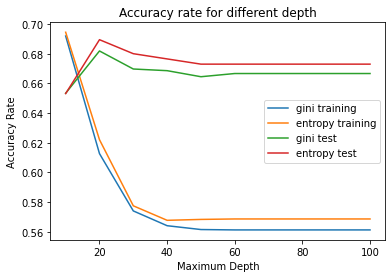

In [ ]:
# plot our results
plt.plot(depth_lst, train_score_lst[0], label = 'gini training')
plt.plot(depth_lst, train_score_lst[1], label = 'entropy training')
plt.plot(depth_lst, test_score_lst[0], label = 'gini test')
plt.plot(depth_lst, test_score_lst[1], label = 'entropy test')

#plt.plot(depth_lst, score_lst[2], label = 'log_loss')
plt.title('Accuracy rate for different depth')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy Rate')
plt.legend()
fig1 = plt.gcf()
plt.show()
fig1.savefig('DecisionTree1.png')

We tried to select the best attribute to improve our model, the way we did it is combine the cross-validation
and accuracy rate. We used 10-fold cross-validation and in each fold, we use accuracy as our score to
compare them. The most important parameter for a decision tree is the maximum depth. The depth of
the tree is the layer of the nodes, which means the root nodes have a depth of 0, the sub-node of the root
nodes has a depth of 1, and so on. So we compare all the depths from 10 to 100 breaking by 10 to find out what is the best depth we should fit for our tree model. Also, we still have to compare two different
measurements of each node, which are gini and entropy. From the figure above, we can find out how
the training accuracy and how the test accuracy are doing as the depth increases for both measurements.
For gini, we can see that the training error is decreasing as the depth is increasing. This is not normal,
cause it usually should be in the opposite way. So maybe for our cases, our model is an under-fitting
model. Then we just select the depth by selecting the higher test accuracy rate. And for entropy, we can
use the same method to find the depth, which is 30. So, no matter which measurement, 30 may be the best depth for the tree. Then we find out that no matter the training or testing, the entropy will get
higher accuracy than gini.

In [ ]:
# pick our tree based on the tuning results
treeclf = DecisionTreeClassifier(max_depth=40,criterion='entropy',random_state=0)
#treeovr = OneVsRestClassifier(treeclf)

treeclf.fit(new_train_set, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=40, random_state=0)

In [ ]:
# save pic
fig = plt.figure(figsize=(30,22), dpi=500)
tree.plot_tree(treeclf)
fig.savefig('imagename.png')

In [ ]:
predict_y = treeclf.predict(validation_set)
print("Accuracy:",metrics.accuracy_score(validation_respond, predict_y))

Accuracy: 0.68456


In [ ]:
print(treeclf.tree_.node_count)

29981


In [ ]:
# print our results

confusion = confusion_matrix(validation_respond, predict_y)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(validation_respond, predict_y)))

print('Micro Precision: {:.2f}'.format(precision_score(validation_respond, predict_y, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(validation_respond, predict_y, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(validation_respond, predict_y, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(validation_respond, predict_y, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(validation_respond, predict_y, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(validation_respond, predict_y, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(validation_respond, predict_y, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(validation_respond, predict_y, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(validation_respond, predict_y, average='weighted')))


print('\nClassification Report\n')
print(classification_report(validation_respond, predict_y, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[1463  879   71]
 [ 767 4659 1059]
 [  56 1111 2435]]

Accuracy: 0.68

Micro Precision: 0.68
Micro Recall: 0.68
Micro F1-score: 0.68

Macro Precision: 0.67
Macro Recall: 0.67
Macro F1-score: 0.67

Weighted Precision: 0.68
Weighted Recall: 0.68
Weighted F1-score: 0.68

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.61      0.62      2413
     Class 2       0.70      0.72      0.71      6485
     Class 3       0.68      0.68      0.68      3602

    accuracy                           0.68     12500
   macro avg       0.67      0.67      0.67     12500
weighted avg       0.68      0.68      0.68     12500



In [ ]:
cm_df = pd.DataFrame(confusion,
                     index = ['Good','Standard','Poor'], 
                     columns = ['Good','Standard','Poor'])

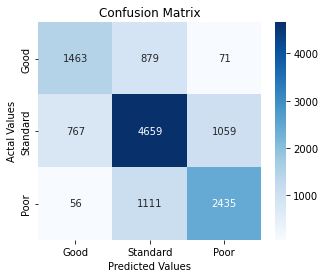

In [ ]:
# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True,cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
fig1 = plt.gcf()
plt.show()
fig1.savefig('Confustionmatrix1.png')

Since our case is a multi-class problem, we can not analyze the matrix directly. We applied the one
versus rest approach to see how was our model, let us look at good versus rest. For now, we only care
about whether the credit score outcome is good or not, which means treating standard and poor as one
class. So the true positive for good vs rest is 1463, the false negative is 879+71 = 950, the false positive
is 767 + 56 = 823, and the true negative is 4659 + 1059 + 1111 + 2435 = 9264. Based on that, we also
calculated the precision and recall for each class versus the rest. We can count that for all the other two
cases. Also from the confusion matrix, we can see that the true positive for the standard class is the
biggest.

## Random Forest Classifier

In [ ]:
# 77
n_estimator = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
criterion_list = ['gini', 'entropy']
#randfclf = BaggingClassifier()
train_score_lst = []
test_score_lst = []
for item in ['gini', 'entropy']:
  train_lst = []
  test_lst = []
  for i in depth_lst:
    treeclf = RandomForestClassifier(n_estimators = i, criterion = item)
    scores=cross_val_score(estimator = treeclf,X=new_train_set,y =train_y,cv = 10)
    # for validation set
    treeclf.fit(new_train_set, train_y)
    predict_y = treeclf.predict(validation_set)
    test_lst.append(metrics.accuracy_score(validation_respond, predict_y))
    print(scores)
    print(np.mean(scores))
    train_lst.append(np.mean(scores))
  #plt.plot(depth_lst, item_lst)

train_score_lst.append(train_lst)
test_score_lst.append(test_lst)

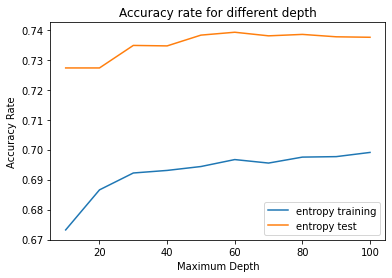

In [ ]:
# plot our results and save fig

plt.plot(depth_lst, train_score_lst[0], label = 'entropy training')
#plt.plot(depth_lst, train_score_lst[1], label = 'entropy training')
plt.plot(depth_lst, test_score_lst[0], label = 'entropy test')
#plt.plot(depth_lst, test_score_lst[1], label = 'entropy test')

#plt.plot(depth_lst, score_lst[2], label = 'log_loss')
plt.title('Accuracy rate for different depth')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy Rate')
plt.legend()
fig1 = plt.gcf()
plt.show()
fig1.savefig('randomforest1.png')

From the figure above, we can see that test accuracy is like a u shape and training accuracy will also
increase. This is normal, cause once the test accuracy begins to decrease that means our model is over
fitting. So we select 60 to be the best number of trees we need for the random forest model. Then we
can have our test accuracy rate of 0.7376.

In [ ]:
# choose random forest based on tuning
treeclf = RandomForestClassifier(n_estimators = 60, criterion = 'entropy')
treeclf.fit(new_train_set, train_y)

In [ ]:
fig = plt.figure(figsize=(30,22), dpi=500)
tree.plot_tree(treeclf[0])
fig.savefig('imagename1.png')

In [ ]:
predict_y = treeclf.predict(validation_set)
print("Accuracy:",metrics.accuracy_score(validation_respond, predict_y))

Accuracy: 0.7376


In [ ]:
confusion = confusion_matrix(validation_respond, predict_y)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(validation_respond, predict_y)))

print('Micro Precision: {:.2f}'.format(precision_score(validation_respond, predict_y, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(validation_respond, predict_y, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(validation_respond, predict_y, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(validation_respond, predict_y, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(validation_respond, predict_y, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(validation_respond, predict_y, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(validation_respond, predict_y, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(validation_respond, predict_y, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(validation_respond, predict_y, average='weighted')))


print('\nClassification Report\n')
print(classification_report(validation_respond, predict_y, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[1569  838    6]
 [ 588 4911  986]
 [  20  821 2761]]

Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.73
Macro Recall: 0.72
Macro F1-score: 0.73

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

     Class 1       0.72      0.65      0.68      2413
     Class 2       0.75      0.76      0.75      6485
     Class 3       0.74      0.77      0.75      3602

    accuracy                           0.74     12500
   macro avg       0.73      0.72      0.73     12500
weighted avg       0.74      0.74      0.74     12500



In [ ]:
cm_df = pd.DataFrame(confusion,
                     index = ['Good','Standard','Poor'], 
                     columns = ['Good','Standard','Poor'])

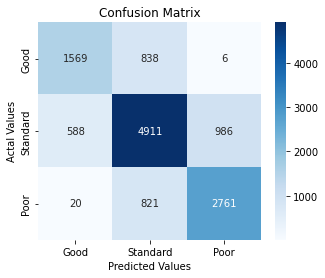

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True,cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
fig1 = plt.gcf()
plt.show()
fig1.savefig('Confustionmatrix2.png')

We can use the same strategy to can see the precision and recall for each class. 

# Limitation and Conclusion

So based on the information in the table above, and the accuracy rate of our validation set, we selected the random forest as our final model to predict on the real test data.
For now, the performance of our best model is still not that good. So we thought there are some
limitations to our model. 

1.   No matter a new training data or the validation set, their month are all between January and August. But for the final prediction data, the actual accuracy
rate might be a little bit lower around 0.7. Because all the prediction data are from month September
to December.  

2.   In our data, there is so many repeated observation from one customer with all the other information being the same. So it might cause some overfitted problems.


# Prediction on the real test data

In [ ]:
treeclf = RandomForestClassifier(n_estimators = 60, criterion = 'entropy')
treeclf.fit(train_data, Credit_Score)
pred = treeclf.predict(test_data)